# Using functional connectivity from the HCP to predict individual characteristics

Connectivity ML Group @ [Neurohackademy 2021](https://neurohackademy.org/)

## But first, import!

In [1]:
# our core libraries
import math
import numpy as np
import pandas as pd
import neuropythy as ny
import nibabel as nib
import ipyvolume as ipv
import random
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix

from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap  # package used to calculate Shap values

In [3]:
# You need to configure neuropythy so that it knows what your
# HCP AWS S3 access key and secret are:

ny.config['hcp_credentials'] = (key, secret)

ny.config['hcp_auto_download'] = True
ny.config['hcp_auto_path'] = '~/hcp_data'

# Next, load the data..

To `netmaps_df` we load "netmaps" which are subject-specific “parcellated connectomes” – for each subject, a nodes x nodes network matrix. See more [here](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP1200-DenseConnectome+PTN+Appendix-July2017.pdf).

To `behavioral_df` we load the data keys. See more [here](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). 

In [326]:
N = 25 # number of ICAs - 15, 25, 50 ,100 ,200 , 300

In [327]:
netmaps_df = pd.read_csv('../../../data/connectivityml/HCP_PTN1200/netmats/3T_HCP1200_MSMAll_d'+str(N)+'_ts2/netmats2.txt', delim_whitespace=True,header=None)
print("Network-matrices data shape:", netmaps_df.shape)
netmaps_df.head()

Network-matrices data shape: (1003, 625)


,0,1,2,3,4,5,6,7,8,9,...,615,616,617,618,619,620,621,622,623,624
0,0,0.48167,-8.4573,7.8182,-0.94641,2.6260,14.4090,-1.84990,1.73550,-3.0523,...,-2.94100,1.98670,-6.1381,-0.99526,1.588200,-0.59560,2.79780,-0.69251,5.5044,0
1,0,-0.21051,-5.9269,2.4759,-1.01590,-1.5387,1.9955,-4.91130,0.82108,-2.6628,...,-0.23727,-1.25340,-3.1831,-0.41514,-1.394700,-0.25233,-0.58857,-0.18795,1.1142,0
2,0,-2.28280,-20.1830,4.5756,-0.74306,-0.9496,4.1836,0.88205,0.37860,-3.1573,...,2.24450,-0.44514,-2.8632,-2.27040,3.624300,0.18470,-1.06380,-1.41320,3.0233,0
3,0,2.67090,-11.9300,8.3285,0.18132,-3.5025,2.4458,-4.83410,-0.29249,-6.6201,...,-1.69010,-0.19591,-1.5448,-2.48340,0.132000,-1.16620,-2.75050,-2.07550,3.6586,0
4,0,1.63180,-4.6537,2.7437,0.48297,2.0215,5.5650,-3.59690,0.60316,-5.7680,...,0.17606,-1.12830,-1.1104,-0.23675,-0.068633,0.51485,-2.05350,-0.35625,4.9078,0


In [328]:
behavioral_df = pd.read_csv('../../../data/connectivityml/unrestricted_pkalra_7_26_2021_17_39_25.csv')
print("Behaviora data shape:", behavioral_df.shape)
behavioral_df.head()

Behaviora data shape: (1206, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


We have netmaps for 1003 subjects so we will need to filter `behavioral_df` a little.

To `subjectsID_df` we load the ordered list of all subjects with complete rfMRI data (recon 1 + recon2) included in this PTN release

In [329]:
subjectsID_df = pd.read_csv('../../../data/connectivityml/HCP_PTN1200/subjectIDs.txt',header=None,names=["Subject"])
print("Subjects ID data shape:", subjectsID_df.shape)
subjectsID_df.head()

Subjects ID data shape: (1003, 1)


,Subject
0,100206
1,100307
2,100408
3,100610
4,101006


We can see that this corresponds to the number of netmaps we have.

In [330]:
filter_behavioral_df = subjectsID_df.merge(behavioral_df, on='Subject', how='inner')

print("Filtered behaviora data shape:", filter_behavioral_df.shape)
filter_behavioral_df.head()

Filtered behaviora data shape: (1003, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80


## Pre-process features matrix

In [331]:
netmapsX_df = pd.DataFrame(data = netmaps_df, columns = range(N*N))
netmapsX_df = netmapsX_df.T.drop_duplicates(keep='first').T
netmapsX_df = netmapsX_df.T.drop_duplicates(keep='last').T
X = netmapsX_df
print("Features matrix shape:", X.shape)
X.head()

Features matrix shape: (1003, 301)


,0,1,2,3,4,5,6,7,8,9,...,521,522,523,524,547,548,549,573,574,599
0,0.0,0.48167,-8.4573,7.8182,-0.94641,2.6260,14.4090,-1.84990,1.73550,-3.0523,...,5.4489,-2.1707,-0.39789,-0.59560,1.341000,-0.35687,2.79780,-0.367790,-0.69251,5.5044
1,0.0,-0.21051,-5.9269,2.4759,-1.01590,-1.5387,1.9955,-4.91130,0.82108,-2.6628,...,5.4564,-1.3788,0.01229,-0.25233,-0.020415,-2.18360,-0.58857,-0.736100,-0.18795,1.1142
2,0.0,-2.28280,-20.1830,4.5756,-0.74306,-0.9496,4.1836,0.88205,0.37860,-3.1573,...,5.1033,-3.4887,-1.30890,0.18470,-0.621790,-2.02660,-1.06380,-1.047600,-1.41320,3.0233
3,0.0,2.67090,-11.9300,8.3285,0.18132,-3.5025,2.4458,-4.83410,-0.29249,-6.6201,...,6.5824,-5.4837,-1.93520,-1.16620,0.026134,2.17250,-2.75050,0.077571,-2.07550,3.6586
4,0.0,1.63180,-4.6537,2.7437,0.48297,2.0215,5.5650,-3.59690,0.60316,-5.7680,...,6.5457,-2.9417,-1.58930,0.51485,0.064168,-2.80550,-2.05350,1.403200,-0.35625,4.9078


## Pre-process predicted values

Here we are going to foucs on the subject gender.

In [332]:
filter_behavioral_df['Gender_i']=np.zeros(shape=(subjectsID_df.shape))
filter_behavioral_df.Gender_i = pd.factorize(filter_behavioral_df.Gender)[0] # Encode the object as an enumerated type or categorical variable.
y_gender = filter_behavioral_df.Gender_i # Gender of Subject
print("y_gender shape:", y_gender.shape)

filter_behavioral_df['Gender_i'].groupby(filter_behavioral_df['Gender']).unique().apply(pd.Series).rename(columns={0:'Labels'}).sort_values(by='Labels')

y_gender shape: (1003,)


,Labels
Gender,
M,0
F,1


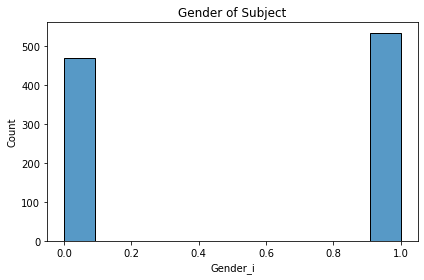

In [333]:
fig, ax = plt.subplots()
sns.histplot(y_gender, ax=ax)
ax.set_title("Gender of Subject")
fig.tight_layout()

## Time for Random forests!

Data and estimators exploration was done in a separate notebook..

### [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Here we will prdict the gender of subjects in our dataset from our network-matrices data has gave us the best results...

In [334]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y_gender, test_size=0.2,stratify=y_gender,random_state=1)

In [335]:
rf = RandomForestClassifier(random_state=1)

rf.fit(xtrain, ytrain) # Build a forest of trees from the training set (X, y).

score = rf.score(xtest, ytest) # Return the mean accuracy on the given test data and labels.
print("Test set score: ", score) 

ypred = rf.predict(xtest) # Predict class for X.

Test set score:  0.7960199004975125


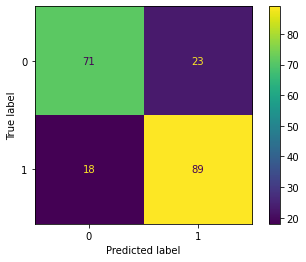

In [336]:
# View confusion matrix for test data and predictions
plot_confusion_matrix(rf, xtest, ytest) # Plot Confusion Matrix.
plt.savefig('output/confusion_matrix_'+str(N)+'.png')

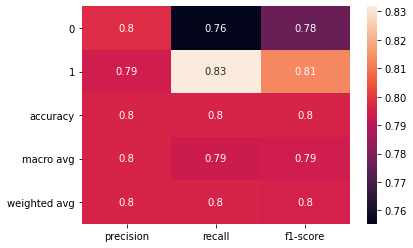

In [337]:
cr = classification_report(ytest, ypred,output_dict=True) # Build a text report showing the main classification metrics.
sns_plot = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True) # plot scikit-learn classification report
sns_plot.figure.savefig("output/classification_report_"+str(N)+".png")

#### Visualizing trees
We can plot individual decision trees - 

In [338]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image, display

def plot_graphviz_tree(tree):
    """
    Helper function that takes a tree as input, calls sklearn's export_graphviz
    function to generate an image of the tree using graphviz, and then
    plots the result in-line.
    """
    export_graphviz(tree, out_file='tree.dot', max_depth=3, filled=True,
                    feature_names=X.columns, impurity=False, rounded=True,
                    proportion=False, precision=2);

    call(['dot', '-Tpng', 'tree.dot', '-o', 'output/tree_'+str(N)+'.png', '-Gdpi=600'])
    display(Image(filename = 'output/tree_'+str(N)+'.png'));

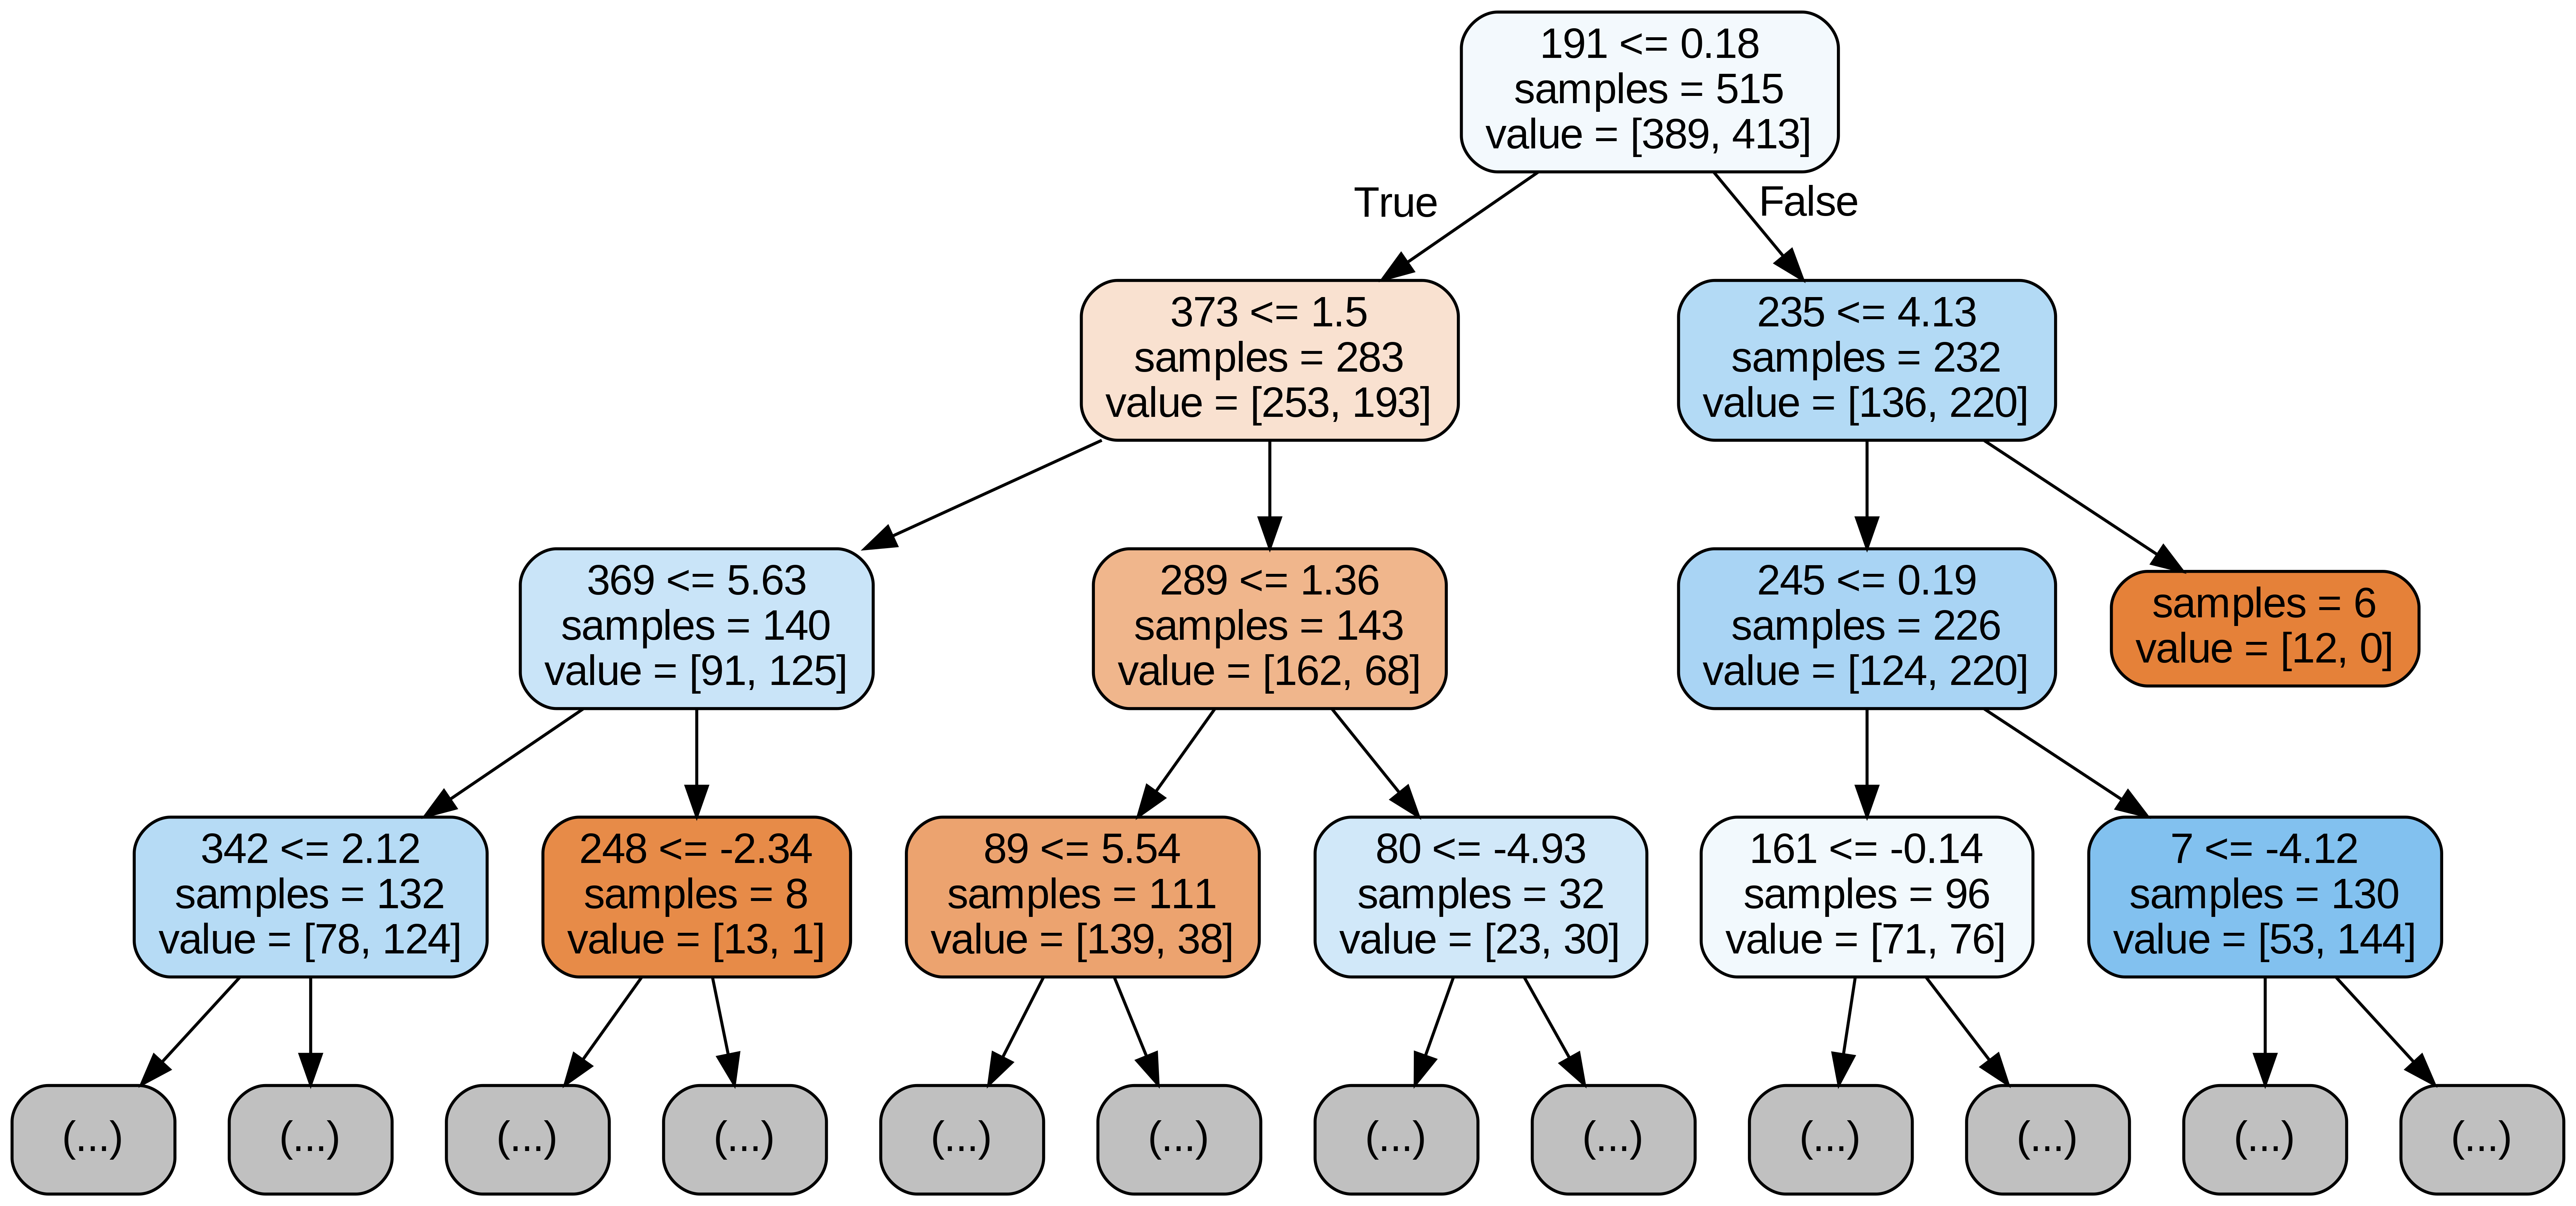

In [339]:
# First tree in the forest
plot_graphviz_tree(rf.estimators_[0]);

#### Interpreting random forests

##### Feature importances

Unlike regression-based methods, random forests don't have linear coefficientsso we look at the feature importances, to tell us how each feature contributes to the overall prediction.

In [340]:
pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

169    0.014111
171    0.012787
113    0.012097
496    0.012027
124    0.011018
123    0.011016
38     0.010796
222    0.010486
444    0.008564
212    0.008500
dtype: float64

##### SHAP values
To interpret our results we will look at the SHAP values of our model.
See more [here](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a).

SHAP feature importance is an alternative to standard feature importance based on magnitude of feature attributions. The feature importance is useful, but contains no information beyond the importances. For a more informative plot, we will next look at the summary plot.

The SHAP summary plot is made of all the dots in the test data. Showing:
- **Feature importance:** Variables are ranked in descending order.
- **Impact:** The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- **Original value:** Color shows whether that variable is high (in red) or low (in blue) for that observation.


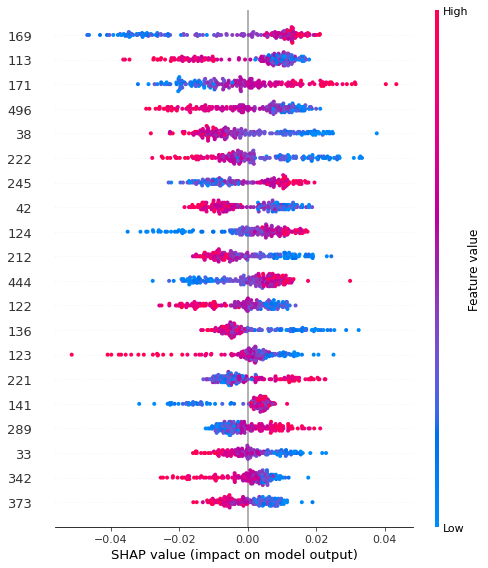

In [341]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of xtest rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(xtest)

# Make plot. Index of [1] is explained in text below.

fig = shap.summary_plot(shap_values[1], xtest, show=False)
plt.savefig('output/summary_plot_xtest_'+str(N)+'.png')

#### Single subject interpretation
We will look at SHAP values for a random row of the dataset.

##### SHAP values
For context, we'll look at the raw predictions before looking at the SHAP values.

In [342]:
row_to_show = 5
data_for_prediction = xtest.loc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

rf.predict_proba(data_for_prediction_array)

array([[0.6, 0.4]])

In [343]:
print("Subject evaluated:",subjectsID_df.Subject[row_to_show])

Subject evaluated: 101107


In [344]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction, show=False)
# plt.savefig('force_plot_hcp_'+str(subjectsID_df.Subject[row_to_show])+'_'+str(N)+'.png')

The SHAP values of all features sum up to explain why the prediction was different from the baseline. This allows us to decompose a prediction in a graph like this where:

- The **output value** is the prediction for that observation (the prediction of the subject evluated).
 - The **base value** is the value that would be predicted if we did not know any features for the current output (the mean prediction, or mean(yhat)).
 - **Red/blue:** Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
 
##### TOP 5 Most important ICA's

In [345]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(xtest.columns,vals)),columns=['netmat_col','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head()

,netmat_col,feature_importance_vals
142,169,0.026492
212,289,0.021169
287,496,0.016023
144,171,0.015498
116,136,0.014021


In [346]:
edge_df = pd.DataFrame(columns = ['netmat_col','Node1', 'Node2', 'Weight'])
countlist = list() # if node1,node2 weight is saved no need to save node2,node1

for index, row in tqdm(netmaps_df.iterrows(), total=netmaps_df.shape[0]):
    netmat_col = 0
    if index == row_to_show:
        row2mat = row.values.reshape(N,N)
        for node1 in range(N):
            for node2 in range(N):
                if node1!=node2:
                    if (node2, node1) not in countlist:
                        countlist.append((node1, node2))
                        curr_edge = {'netmat_col': netmat_col, 'Node1': node1, 'Node2': node2, 'Weight':row2mat[node1][node2]}
                        edge_df = edge_df.append(curr_edge, ignore_index = True)
                netmat_col = netmat_col + 1

100%|██████████| 1003/1003 [00:00<00:00, 2040.60it/s]


In [347]:
# Explore brain-free network model visualization
feature_importance

,netmat_col,feature_importance_vals
142,169,2.649188e-02
212,289,2.116923e-02
287,496,1.602310e-02
144,171,1.549795e-02
116,136,1.402097e-02
...,...,...
295,547,1.237486e-05
176,220,6.762849e-06
113,133,3.273359e-06
55,60,7.565106e-08


In [348]:
f = open('output/top5_'+str(subjectsID_df.Subject[row_to_show])+'_'+str(N)+'.txt', "w")

for i in range(5):
    feature = feature_importance.netmat_col.values[i]
    print("Important feature #: ",feature)
    f.write("Important feature #: " + str(feature)+"\n")
    ICA_Node1 = edge_df.loc[edge_df['netmat_col'] == feature, 'Node1']
    ICA_Node2 = edge_df.loc[edge_df['netmat_col'] == feature, 'Node2']

    print("Node 1:",ICA_Node1.iloc[0])
    f.write("Node 1: " + str(ICA_Node1.iloc[0])+"\n")
    print("Node 2:",ICA_Node2.iloc[0])
    f.write("Node 2: " + str(ICA_Node2.iloc[0])+"\n")
f.close()

Important feature #:  169
Node 1: 6.0
Node 2: 19.0
Important feature #:  289
Node 1: 11.0
Node 2: 14.0
Important feature #:  496
Node 1: 19.0
Node 2: 21.0
Important feature #:  171
Node 1: 6.0
Node 2: 21.0
Important feature #:  136
Node 1: 5.0
Node 2: 11.0


In [349]:
edge_df

,netmat_col,Node1,Node2,Weight
0,1.0,0.0,1.0,0.23194
1,2.0,0.0,2.0,-14.51600
2,3.0,0.0,3.0,6.90900
3,4.0,0.0,4.0,-1.25650
4,5.0,0.0,5.0,-1.38910
...,...,...,...,...
295,548.0,21.0,23.0,0.97495
296,549.0,21.0,24.0,-0.78181
297,573.0,22.0,23.0,1.31610
298,574.0,22.0,24.0,-1.47550


In [350]:
edge_df['weight'] = 1

for ind in (feature_importance.netmat_col[:5].index):
    print(ind)
    edge_df.loc[ind-1,'weight'] = 5
edge_df

142
212
287
144
116


,netmat_col,Node1,Node2,Weight,weight
0,1.0,0.0,1.0,0.23194,1
1,2.0,0.0,2.0,-14.51600,1
2,3.0,0.0,3.0,6.90900,1
3,4.0,0.0,4.0,-1.25650,1
4,5.0,0.0,5.0,-1.38910,1
...,...,...,...,...,...
295,548.0,21.0,23.0,0.97495,1
296,549.0,21.0,24.0,-0.78181,1
297,573.0,22.0,23.0,1.31610,1
298,574.0,22.0,24.0,-1.47550,1


In [351]:
# print(edge_df.loc[13])
edge_df.loc[edge_df['netmat_col'].isin(feature_importance.netmat_col[:5])]

,netmat_col,Node1,Node2,Weight,weight
115,136.0,5.0,11.0,-4.5083,5
141,169.0,6.0,19.0,-5.3185,5
143,171.0,6.0,21.0,-2.9680,5
211,289.0,11.0,14.0,2.3290,5
286,496.0,19.0,21.0,2.6853,5


In [352]:
import networkx as nx

# G=nx.from_pandas_edgelist(edge_df, 'Node1', 'Node2')
G=nx.from_pandas_edgelist(edge_df, 'Node1', 'Node2', edge_attr='weight')
# G=nx.from_pandas_edgelist(edge_df, 'Node1', 'Node2', edge_attr=edge_df.astype({'Weight': 'int32'}))

In [353]:
# number of ICAs - 15, 25, 50 ,100 ,200 , 300

nx.write_gexf(G, "/home/jovyan/Hackathon/code/tpatpa/connectivityml/gephi-25-top5-weighted.gexf")

Knowing the ICA's that are part of the most important feature we can plot them on our single subject brain

In [30]:
# Get a sample HCP subject:
sub = ny.hcp_subject(subjectsID_df.Subject[row_to_show])
sub

Subject(<101107>, <'s3://hcp-openaccess/HCP_1200/101107'>)

In [31]:
# Load the CIFTI file:
cii_filename = '~/data/connectivityml/HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d'+str(N)+'.ica/melodic_IC.dscalar.nii'
cii_obj = ny.load(cii_filename)

# Split the CIFTI object into hemisphere/subvoxel data:
(lh_data, rh_data, subvox_data) = ny.hcp.cifti_split(cii_obj)

# These data should be (N(data-points) x vertices)
lh_data.shape

(15, 32492)

In [32]:
# sub.lh and sub.rh are the "native" (FreeSurfer) hemispheres;
# sub.hemis['lh_LR32k'] and sub.hemis['rh_LR32k'] are the
# HCP subject-aligned fs_LR hemispheres (with 32k resolution).
lh_hemi_native = sub.lh
rh_hemi_native = sub.rh

# The 32492 size indicates this is a 32k LR hemisphere:
lh_hemi = sub.hemis['lh_LR32k']
rh_hemi = sub.hemis['rh_LR32k']

**ICA 1**

In [33]:
# We can make an ipyvolume figure to plot both hemispheres on:
fig = ipv.figure()
# Then plot each hemisphere using whichever ICA component we
# want to visualize:

ICA_Node1 = int(edge_df.loc[edge_df['netmat_col'] == feature_importance.netmat_col.values[0], 'Node1'])
ny.cortex_plot(lh_hemi, surface='inflated', color=lh_data[ICA_Node1], cmap='hot', figure=fig)
ny.cortex_plot(rh_hemi, surface='inflated', color=rh_data[ICA_Node1], cmap='hot', figure=fig)

neuropythy: NOTE: due to a bug in ipyvolume, camera views cannot currently be set by neuropythy; however, if you click the reset (home) button in the upper-left corner of the figure, the requested view will be fixed.


Figure(camera=PerspectiveCamera(fov=0.644570721372708, position=(0.0, -100.0, 0.0), projectionMatrix=(1.0, 0.0…

In [34]:
ipv.pylab.save('output/most_important_ICA1_'+str(subjectsID_df.Subject[row_to_show])+'_'+str(N)+'.html',title='Most important feature ICA 1')

**ICA 2**

In [35]:
# We can make an ipyvolume figure to plot both hemispheres on:
fig = ipv.figure()
# Then plot each hemisphere using whichever ICA component we
# want to visualize:

ICA_Node2 = int(edge_df.loc[edge_df['netmat_col'] == feature_importance.netmat_col.values[0], 'Node2'])
ny.cortex_plot(lh_hemi, surface='inflated', color=lh_data[ICA_Node2], cmap='hot', figure=fig)
ny.cortex_plot(rh_hemi, surface='inflated', color=rh_data[ICA_Node2], cmap='hot', figure=fig)

neuropythy: NOTE: due to a bug in ipyvolume, camera views cannot currently be set by neuropythy; however, if you click the reset (home) button in the upper-left corner of the figure, the requested view will be fixed.


Figure(camera=PerspectiveCamera(fov=0.644570721372708, position=(0.0, -100.0, 0.0), projectionMatrix=(1.0, 0.0…

In [36]:
ipv.pylab.save('output/most_important_ICA2_'+str(subjectsID_df.Subject[row_to_show])+'_'+str(N)+'.html',title='Most important feature ICA 2')